In [1]:
# 导入数据
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# 定义超参数
image_size = 28
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 构建pipeline，对图像处理
pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

In [4]:
# 下载、加载数据集
train_dataset = dsets.MNIST(root='./data',
                        train=True,
                        download=True,
                        transform=pipeline) 
test_dataset = dsets.MNIST(root='./data',
                       train=True,
                       download=True,
                       transform=pipeline) 

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          sampler=sampler_test)

In [5]:
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 4, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding=2)
        
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = self.fc1(x)
        x = F.relu(x)
        
        # using dropout function
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x
    
    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        
        return (feature_map1, feature_map2)

In [6]:
def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred).to(device)).sum()
    return rights, len(labels)

In [7]:
# net = ConvNet().to(device)
net = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

record = []
weights = []

for epoch in range(num_epochs):
    train_rights = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        # data, target = Variable(data), Variable(target)
        net.train()
        
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = rightness(output, target)
        train_rights.append(right)
        
        if batch_idx % 100 == 0:
            net.eval()
            val_rights = []
            
            for (data, target) in validation_loader:
                data, traget = Variable(data).to(device), Variable(target).to(device)
                # data, traget = Variable(data), Variable(target)
                output = net(data)
                right = rightness(output, target)
                val_rights.append(right)
            
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            print('训练周期:{}[{}/{}({:.0f}%)]\t, Loss:{:.6f}\t, 训练正确率:{:.2f}%\t, 校检正确率:{:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                100. * train_r[0] / train_r[1],
                100. * val_r[0] / val_r[1]))
            
            record.append(((100 - 100. * train_r[0] / train_r[1]).cpu(),
                           (100 - 100. * val_r[0] / val_r[1]).cpu()))
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                           net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])
#         print('\r训练进度{:.2f}%'.format((epoch+1) / (num_epochs+1) * 100), end='')

训练周期:0[0/60000(0%)]	, Loss:2.321898	, 训练正确率:12.50%	, 校检正确率:8.76%
训练周期:0[800/60000(11%)]	, Loss:2.237582	, 训练正确率:20.41%	, 校检正确率:36.88%
训练周期:0[1600/60000(21%)]	, Loss:1.344318	, 训练正确率:38.27%	, 校检正确率:65.48%
训练周期:0[2400/60000(32%)]	, Loss:0.530095	, 训练正确率:50.87%	, 校检正确率:84.90%
训练周期:0[3200/60000(43%)]	, Loss:0.544300	, 训练正确率:59.87%	, 校检正确率:88.98%
训练周期:0[4000/60000(53%)]	, Loss:0.293539	, 训练正确率:65.54%	, 校检正确率:90.88%
训练周期:0[4800/60000(64%)]	, Loss:0.384362	, 训练正确率:69.55%	, 校检正确率:91.58%
训练周期:0[5600/60000(75%)]	, Loss:0.345593	, 训练正确率:72.58%	, 校检正确率:91.58%
训练周期:0[6400/60000(85%)]	, Loss:0.352839	, 训练正确率:74.93%	, 校检正确率:92.68%
训练周期:0[7200/60000(96%)]	, Loss:0.148694	, 训练正确率:76.91%	, 校检正确率:93.22%
训练周期:1[0/60000(0%)]	, Loss:0.223606	, 训练正确率:93.75%	, 校检正确率:93.78%
训练周期:1[800/60000(11%)]	, Loss:0.163157	, 训练正确率:93.02%	, 校检正确率:94.24%
训练周期:1[1600/60000(21%)]	, Loss:0.214998	, 训练正确率:93.50%	, 校检正确率:94.76%
训练周期:1[2400/60000(32%)]	, Loss:0.113106	, 训练正确率:93.64%	, 校检正确率:94.84%
训练周期:1[3200/60000(43%)]	, Loss:

训练周期:11[6400/60000(85%)]	, Loss:0.009579	, 训练正确率:98.90%	, 校检正确率:99.02%
训练周期:11[7200/60000(96%)]	, Loss:0.017445	, 训练正确率:98.92%	, 校检正确率:99.10%
训练周期:12[0/60000(0%)]	, Loss:0.014865	, 训练正确率:100.00%	, 校检正确率:99.06%
训练周期:12[800/60000(11%)]	, Loss:0.009445	, 训练正确率:99.09%	, 校检正确率:99.20%
训练周期:12[1600/60000(21%)]	, Loss:0.060645	, 训练正确率:99.12%	, 校检正确率:99.20%
训练周期:12[2400/60000(32%)]	, Loss:0.029124	, 训练正确率:99.09%	, 校检正确率:99.08%
训练周期:12[3200/60000(43%)]	, Loss:0.071423	, 训练正确率:99.05%	, 校检正确率:99.30%
训练周期:12[4000/60000(53%)]	, Loss:0.003920	, 训练正确率:99.00%	, 校检正确率:99.32%
训练周期:12[4800/60000(64%)]	, Loss:0.003782	, 训练正确率:99.01%	, 校检正确率:99.04%
训练周期:12[5600/60000(75%)]	, Loss:0.059147	, 训练正确率:99.01%	, 校检正确率:99.16%
训练周期:12[6400/60000(85%)]	, Loss:0.033163	, 训练正确率:98.98%	, 校检正确率:99.36%
训练周期:12[7200/60000(96%)]	, Loss:0.021507	, 训练正确率:98.99%	, 校检正确率:99.24%
训练周期:13[0/60000(0%)]	, Loss:0.008481	, 训练正确率:100.00%	, 校检正确率:99.30%
训练周期:13[800/60000(11%)]	, Loss:0.056501	, 训练正确率:99.03%	, 校检正确率:99.28%
训练周期:13[1600/6

In [8]:
net.eval()
vals = []

for data, target in test_loader:
    with torch.no_grad():
        data, target = Variable(data).to(device), Variable(target).to(device)
        # data, target = Variable(data), Variable(target)
    output = net(data)
    val = rightness(output, target)
    vals.append(val)
    
right = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * right[0] / right[1]
right

(tensor(54623, device='cuda:0'), 55000)

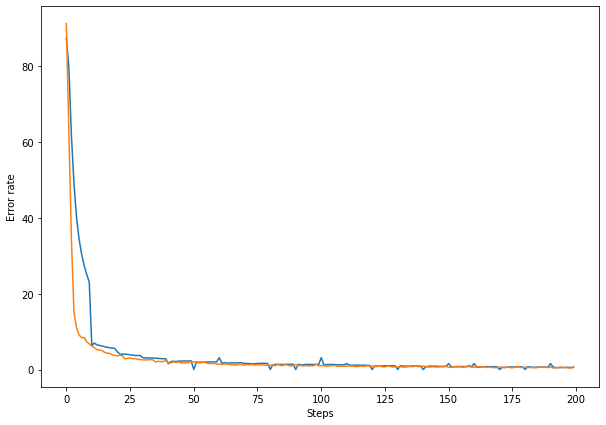

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(record)
plt.xlabel('Steps')
plt.ylabel('Error rate')
# plt.savefig('../../期末作业/figures/手写数字体_训练损失曲线_nodropout.png', dpi=900)

In [10]:
right_rate

tensor(0.9931, device='cuda:0')